## Simplest possible constraint propagation test
Two one dimensional sets

In [1]:
from pydrake.all import (
    GraphOfConvexSets,
    HPolyhedron,
    VPolytope,
    RandomGenerator,
)
import numpy as np
import matplotlib.pyplot as plt
from large_gcs.geometry.polyhedron import Polyhedron

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04


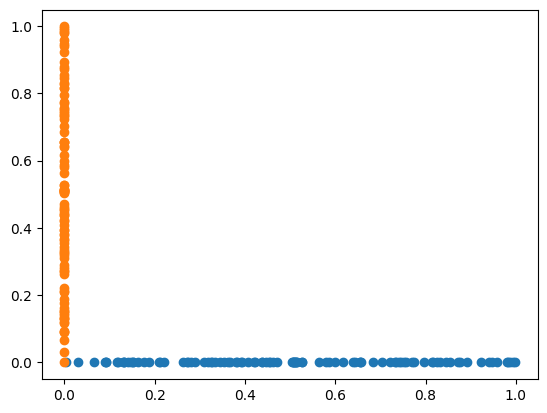

In [2]:
def get_samples(set, n_samples=100):
    samples = []
    generator = RandomGenerator()
    try:
        samples.append(set.UniformSample(generator))
        for i in range(n_samples - 1):
            samples.append(
                set.UniformSample(generator, previous_sample=samples[-1])
            )
    except:
        print("Warning: failed to sample convex set")
    return samples

gcs = GraphOfConvexSets()
A_X = np.array([[-1],[1]])
A_Y = A_X
b_X = np.array([0,1])
b_Y = b_X
X_poly = HPolyhedron(A_X, b_X)
Y_poly = HPolyhedron(A_X, b_X)
# Plot samples using matplotlib
X_samples = get_samples(X_poly, 100)
plt.scatter(X_samples, np.zeros(len(X_samples)))
Y_samples = get_samples(Y_poly, 100)
plt.scatter(np.zeros(len(Y_samples)), Y_samples)

In [3]:
# Build combined set
A_cX = np.array([[1],[-1]])
A_cY = A_cX
C_c = np.array([[0.5],[0.5]])

B = np.vstack((A_X, np.zeros_like(A_Y), A_cX))
A = np.vstack((np.zeros_like(A_X), A_Y, A_cY))

A_Z = np.vstack((B.T, -B.T, -np.ones_like(B.T)))
b_Z = np.zeros(A_Z.shape[0])
Z_poly = HPolyhedron(A_Z, b_Z)
vi = VPolytope(X_poly)

RuntimeError: QH6050 qhull error: dimension 1 must be > 1

While executing:  | qhull H
Options selected for Qhull 2020.2.r 2020/08/31:
  run-id 1415156434  Halfspace  _pre-merge  _zero-centrum  _maxoutside  0


Seems like this doesn't work for one dimension, try a 2d example.

## 2D Example

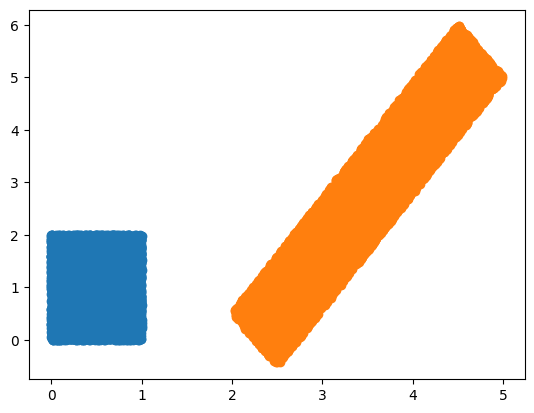

In [4]:
def get_samples(set, n_samples=100):
    samples = []
    generator = RandomGenerator()
    try:
        samples.append(set.UniformSample(generator))
        for i in range(n_samples - 1):
            samples.append(
                set.UniformSample(generator, previous_sample=samples[-1])
            )
    except:
        print("Warning: failed to sample convex set")
    return samples

x_vert = np.array([[0,0], [1,0], [1,2], [0,2]])
y_vert = np.array([[2,0.5], [2.5,-0.5], [5,5], [4.5,6]])
X_poly = HPolyhedron(VPolytope(vertices=x_vert.T))
Y_poly = HPolyhedron(VPolytope(vertices=y_vert.T))
# Plot samples using matplotlib
X_samples = get_samples(X_poly, 10000)
plt.scatter([x[0] for x in X_samples], [x[1] for x in X_samples])
Y_samples = get_samples(Y_poly, 10000)
plt.scatter([x[0] for x in Y_samples], [x[1] for x in Y_samples])

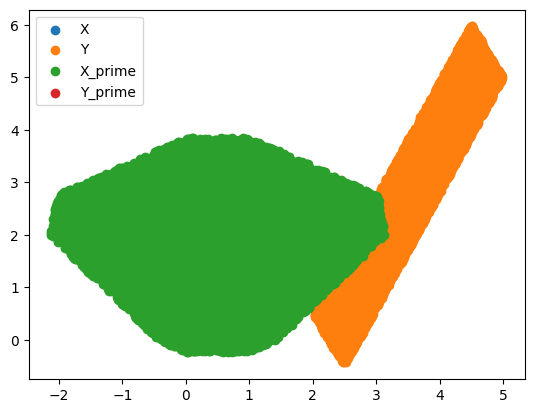

In [5]:
# X_poly = Polyhedron.from_vertices([[0,0], [1,0], [1,2], [0,2]])
# Y_poly = Polyhedron.from_vertices([[2,0.5], [2.5,-0.5], [5,5], [4.5,6]])
# X_poly.plot()
# Y_poly.plot()
# 0Xx + 1Xy + 0Yx + -1Yy <= 0
# 0Xx + -1Xy + 0Yx + 1Yy <= 0
A_cX = np.array([[0, 1],[0, -1]])
A_cY = np.array([[0, -1],[0, 1]])
C_c = np.array([0,0])

A = np.vstack((X_poly.A(), np.zeros_like(Y_poly.A()), A_cX))
B = np.vstack((np.zeros_like(X_poly.A()), Y_poly.A(), A_cY))
C = np.hstack((X_poly.b(), Y_poly.b(), C_c))

# Projection Cone Zy (Onto Y Space)
A_Zy = np.vstack((A.T, -A.T, -np.eye(A.shape[0]), np.eye(A.shape[0])))
b_Zy = np.hstack((np.zeros(A.T.shape[0] * 2 + A.shape[0]), np.ones(A.shape[0])*1000000))
# Projection Cone Zx (Onto X Space)
A_Zx = np.vstack((B.T, -B.T, -np.eye(B.shape[0]), np.eye(B.shape[0])))
b_Zx = np.hstack((np.zeros(B.T.shape[0] * 2 + B.shape[0]), np.ones(B.shape[0])*1000000))
# print(A_Zy.shape)
# print(b_Zy.shape)
Zy_poly = HPolyhedron(A_Zy, b_Zy)
Zx_poly = HPolyhedron(A_Zx, b_Zx)
vi_y = VPolytope(Zy_poly).vertices()
vi_x = VPolytope(Zx_poly).vertices()

# Step 3: Orthogonal projection of the combined set into the Y space
A_Zy = vi_y.T @ B
b_Zy = vi_y.T @ C
# Orthogonal projection of the combined set into the X space
A_Zx = vi_x.T @ A
b_Zx = vi_x.T @ C
Y_prime_poly = HPolyhedron(A_Zy, b_Zy)
X_prime_poly = HPolyhedron(A_Zx, b_Zx)

plt.scatter([x[0] for x in X_samples], [x[1] for x in X_samples], label="X")
plt.scatter([x[0] for x in Y_samples], [x[1] for x in Y_samples], label="Y")
X_prime_samples = get_samples(X_prime_poly, 10000)
plt.scatter([x[0] for x in X_prime_samples], [x[1] for x in X_prime_samples], label="X_prime")
Y_prime_samples = get_samples(Y_prime_poly, 10000)
plt.scatter([x[0] for x in Y_prime_samples], [x[1] for x in Y_prime_samples], label="Y_prime")

plt.legend()